In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os, glob
import tensorflow as tf
import cv2
import random
import pandas as pd
from skimage.io import imread
from PIL import Image, ImageFile
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.models import model_from_json
from keras.models import load_model

In [2]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
train_dir = ('training/training/')
test_dir = ('validation/validation/')

In [23]:
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
labels = pd.read_csv("monkey_labels.txt", names=cols, skiprows=1)
labels

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [24]:
labels = labels['Common Name']
labels

0     mantled_howler                
1     patas_monkey                  
2     bald_uakari                   
3     japanese_macaque              
4     pygmy_marmoset                
5     white_headed_capuchin         
6     silvery_marmoset              
7     common_squirrel_monkey        
8     black_headed_night_monkey     
9     nilgiri_langur                
Name: Common Name, dtype: object

In [6]:
LR = 1e-3
height=150
width=150
channels=3
seed=1337
batch_size = 64
num_classes = 10
epochs = 200
data_augmentation = True
num_predictions = 20

# Training generator
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(height,width),
                                                    batch_size=batch_size,
                                                    seed=seed,
                                                    shuffle=True,
                                                    class_mode='categorical')

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(height,width), 
                                                  batch_size=batch_size,
                                                  seed=seed,
                                                  shuffle=False,
                                                  class_mode='categorical')

train_num = train_generator.samples
validation_num = validation_generator.samples 

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [7]:
base_model=tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(150, 150, 3),
    pooling='avg',
    
    classifier_activation="softmax",
)

In [8]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [9]:
model=Sequential()
model.add(base_model)

model.add(Dense(256,activation='relu'))
model.add(Dense(10,activation='softmax'))

In [10]:
epochs=20
batch_size=128
red_lr=ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=2, verbose=1)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 256)               131328    
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 10)                2570      
Total params: 14,848,586
Trainable params: 14,848,586
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])

C:\Users\Bob\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [13]:
history = model.fit_generator(train_generator,
                              steps_per_epoch= train_num // batch_size,
                              epochs=epochs,
                              validation_data=validation_generator,
                              validation_steps= validation_num // batch_size,
                               
                              verbose = 1
                             )

C:\Users\Bob\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
8/8 [==============================] - 155s 19s/step - loss: 2.3095 - accuracy: 0.1602 - val_loss: 2.2135 - val_accuracy: 0.3125
Epoch 2/20
8/8 [==============================] - 133s 16s/step - loss: 2.0804 - accuracy: 0.2576 - val_loss: 1.9866 - val_accuracy: 0.3047
Epoch 3/20
8/8 [==============================] - 157s 20s/step - loss: 1.7818 - accuracy: 0.3809 - val_loss: 1.6574 - val_accuracy: 0.4141
Epoch 4/20
8/8 [==============================] - 143s 17s/step - loss: 1.4948 - accuracy: 0.4956 - val_loss: 1.2653 - val_accuracy: 0.5312
Epoch 5/20
8/8 [==============================] - 137s 16s/step - loss: 1.3660 - accuracy: 0.5502 - val_loss: 1.1106 - val_accuracy: 0.6328
Epoch 6/20
8/8 [==============================] - 150s 19s/step - loss: 1.1449 - accuracy: 0.6270 - val_loss: 0.9563 - val_accuracy: 0.6953
Epoch 7/20
8/8 [==============================] - 169s 21s/step - loss: 0.8545 - accuracy: 0.7140 - val_loss: 0.6567 - val_accuracy: 0.8047
Epoch 8/20
8/8 [====

In [14]:
pred = model.predict(validation_generator)

pred.shape

(272, 10)

In [15]:
pred = np.argmax(pred[0])

In [16]:
print(pred)

0


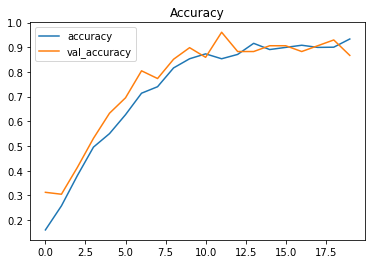

In [17]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

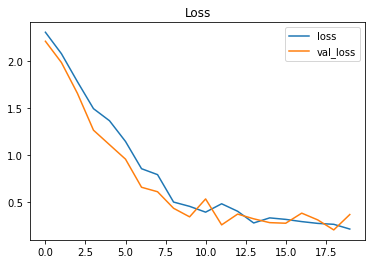

In [18]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [25]:
pred = model.predict(validation_generator)
pred = np.argmax(pred,axis=1)

# Map the label
#labels = (train_images.class_indices)
#labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

The first 5 predictions: [' mantled_howler                ', ' mantled_howler                ', ' mantled_howler                ', ' mantled_howler                ', ' white_headed_capuchin         ']


In [40]:
print(pred[50])
print(validation_generator)

 patas_monkey                  


In [44]:
filepath = ('model/')

model.save(
    filepath,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True,
)

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets
